# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(brain_name)
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Actions in the Environment

The `play_game` function takes a `use_DQN` boolean parameter that by default is set to False.

Here we make use of the Python API to control the agent and receive feedback from the environment. Once this function is called, you will watch the agent's performance.

If `use_DQN` is set to `False`, we will select random actions at each time step, otherwise we will use the Deep-QNetwork (which is defined later in this notebook) to pick the best action based on the DQN's approximation over the environment's state.

In [5]:
def play_game(use_DQN = False):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0
    '''
    When we play the game using DQN, we don't want to use epsilon-greedy-policy.
    Instead, we want to play the game using the strict, greedy-policy.
    Only using the greedy-policy we can trully see how the agent performs based no its training.
    base
    '''
    epsilon = 0
    while True:
        # if we play using DQN, the agent will act based on greedy-policy of the state
        # otherwise we use the equiprobable policy to select randomly any of the available actions
        action = np.int32(agent.act(state, epsilon)) if use_DQN else np.random.randint(action_size)
        
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state
        score += reward
        print("\rScore: {}".format(score), end="")
        if done:
            break 
            
# We can now call the play_game function with a "False" parameter for DQN usage to randomly play the banana game
play_game(use_DQN = False)

Score: 0.0

# Training time!

Now we will define and train our own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# 1. Defining the Neural Network Architecture

Well, in the heart of a Deep Q-Learning system beats the Deep Neural network model that will be used to approximate action selection for any given state.

Our neural network will be trained using regression approach, however we will use it as a classifier among the available action set based on the state input. This means that the input size will be as large as our state size (37) and the output size will be as large our action set size (4).

How it turns that a regression model will be used as a classifier? Well, we have multiple outputs. Each output measures over the same result, the potential total reward. Thus, since we have multiple outputs, all of which measure the same result, the output with the highest score beats the others.

Well, this sounds like classification, where the highest label prevails, and indeed it is. The action to select can be considered as our potential label. As a good refinement we can even use softmax at the final layer if we like, as our outcome won't change, since we will still be considering as the topmost action the one with the highest overall score (no matter if that score is value or probability, we still care about the highest).

We will be defining two identical neural networks (local and target). These neural networks should be clones. They should have the same architecture and same initial weights (θ).  We define a seed so that both the online and the target networks will be initialized equally with a random weight set (θ).

It appears that three fully connected layers of increasing size contributed to faster training, by consuming less episodes to efficiently approximate the best actions for any state input.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=128, fc3_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

# 2. The Agent

The system will utilize a Deep Q-Network that take advantage of the "Experience Replay" and the "Fixed Q-Targets" optimizations.

### 2.1. - The Params

After several configurations test, it appears that the following configurations contribute to a faster training, using less episodes to come up with a policy that meets the needs of this specific Reinforcement Learning task.

In [7]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 5        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 2.2. - Defining the Replay Buffer

To take advantage of the `Experience Replay` optimization we need to create a buffer that will hold the SARS experience tuples in a memory double-ended queue.

#### 2.2.1. - `__init__` constructor

In the initialization section we will create
* a `double-ended queue` with the buffer_size provided to the constructor that will hold the experience tuples.
* a `named tuple` to index the stored experiences by their titles

#### 2.2.2. - `add` method

The add method appends the SARS tuple (given in the parameters) to the memory

#### 2.2.3. - `sample` method

Returns a set of random tuples from the memory buffer based on the batch_size (the number of random samples to return).

#### 2.2.4. - `__len__` method

When using len(myAgent) it will return the size of the memory tuples buffer.

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states  = torch.from_numpy(np.vstack([e.state  for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 2.3. - Defining the Agent class

The agent will train the Deep Q-Networks to explore/exploit which will be used to define the policy that solve the RL problem.

It will consist of the following methods with their described functionality:


#### 2.3.1 - `__init__` constructor method

The constructor will take three parameters, these are `state_size`, `action_size` and `seed`

1) in the constructor we will initialize `two QNetwork instances` with the same random seed as to be initialized with the same weights.  The first QNetwork instance will be the online network, while the target network will be the to compare over the changes of the online network and synchronize with the online network based on the `UPDATE_EVERY` frequency from the parameters above.

2) We will define the `Optimizer`, in our case we will use Adam, with the specified learning rate `LR` as defined from the parameters above.

3) Finally, the agent will instantiate a ReplayBuffer to store its experiences.


#### 2.3.2. - `step` method

This method will add experiences to the buffer.  If our current step matches the amount of steps based on which we wish to perform learning (UPDATE_EVERY), then we will learn based on random SARS tuple samples as long as the memory contains at least as many items as our batch size (128)

#### 2.3.3. - `act` method
The act method will fetch the existing state, then in evaluation mode we make a forward pass the state to the neural network and get the output with the scores for the available actions. Now according to the epsilon-greedy-policy probabilities we will either select the highest scored action, or select randomly among any of the available actions.

#### 2.3.4. - `learn` method
Q-Learning (SarsaMax) dictates that the next action we will take into account is the one that always maximizes the reward at the next state based on our policy. Now applying Q-Learning in a Deep-QN...

So the `Q_targets_next` will obtain the the highest action for next state, populated by our batch size.

We use this to calculate our `Q_targets` based on our existing `rewards`, so we have a complete SARSA now.

Ok, so far we have obtained our SARSA and its now time to see how this change compares to our existing network weights configuration so we make any alterations necessary!

Now with a forward call to our DQN we can `gather` the state values, which we call `Q_expected`.

Great... now its time to measure the error on our Neural Network. To do so, we will use a regression error function, the `MSE (Mean of Squared Errors)`, which is used to quantify the distance between `Q_expected` and and `Q_targets`. This distance is our error.

Cool! Now all that is left is utilize this error to actually train the neural network, expecting to get a new smaller-error.

* So we zero our gradients
* quantify the loss to all weights using backpropagation by using `backward()` call
* and finally apply the gradient change to existing weights using the optimizer's `step()` to come up with new weights

Ok! Great! We have finished our learning step now!

The only thing is that our target network should sync to our local (online) network until the next learning step (whenever it will reoccur based on the UPDATE_EVERY variable).

So we will `soft_update` our target network to match our local network.

#### 2.3.5. - `soft_update` method
Ok, finally we reach the point where the target network will sync to our online local network! That means that learning has concluded, and we sync the networks to prepare for our next learning.

The soft update takes a constant τ (tau), which defines by how much the target network will match the weight configuration of the local network. Passing value 1 will result in clones (fully sync), while anything lower than that will reflect slight variations between the old weights to the new ones. Setting a tau of 0 will never update the target network and it will always keep its original initial configuration.

In [9]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)




### 2.4 Initializing the agent object

Now we have all the tools to initialize the agent which will explore/exploit the banana world!

We initialize the agent setting the

* `state_size = brain.vector_observation_space_size`, which is `37`
* `action_size = brain.vector_action_space_size`, which is `4`

In [10]:
agent = Agent(state_size  = brain.vector_observation_space_size, 
              action_size = brain.vector_action_space_size, 
              seed = 0)

# 3. Interacting with the Environment to learn

At this stage, we will put everything together so we can interact with the environment for several episodes, until we come up with a good policy estimation via our DQN network, and eventually solve the RL task.

Our DQN method will run for a maximum of 2000 episodes, after which if we have not reached our desired per 100 episodes score, the method will terminate.

In a nutshell, at every episode we will
* Reset the environment
* For each state, loop by getting the current state
    * Follow the epsilon-greedy-policy so the agent acts on that state according policy and epsilon
    * Get observation and reward
    * Use the agent's `step` function as described above to populate the experience buffer and possibly trigger the `learn` function
    
We keep doing this until our average score over 100 episodes is equal or higher than 13 (which relates to gathering 13 yellow bananas on time).

After every 100 episodes we save a `checkpoint` if the average score has increased, but we also overwrite this checkpoint once we reach our goal. Now one might ask, what is the use to save intermediate scores. Well, sometimes you might interrupt this method earlier, and just want to check how your model performs with this "early" training (so it is there just for curiosity reasons).

In [11]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    prv_score = float("-inf")
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # examine the state space 
        state = env_info.vector_observations[0]  
        
        score = 0
        for t in range(max_t):           
            action = np.int32(agent.act(state, eps))       # select the epsilon-greedy action for our state
            
            env_info = env.step(action)[brain_name]        # forward the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if (prv_score < np.mean(scores_window)):
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
       
        prv_score = np.mean(scores_window)
    
        if np.mean(scores_window)>=13.0:
            
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

scores = dqn()

Episode 100	Average Score: 0.91
Episode 200	Average Score: 3.62
Episode 300	Average Score: 5.53
Episode 400	Average Score: 8.55
Episode 500	Average Score: 9.93
Episode 600	Average Score: 12.47
Episode 645	Average Score: 13.03
Environment solved in 645 episodes!	Average Score: 13.03


#### Visualizing the scores per episode

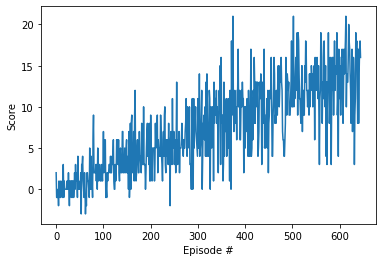

In [12]:
# plot the scores
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 4. Loading the configuration

We can load a previous configuration of the DQN agent's weight (θ) here

In [13]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# 5. Playing the game!

It is now time to use our defined `play_game` function to play the banana game using the defined Deep QNetwork to approximate the best action based on the state input.


### 5.1 Play the game using the DQN policy
Play the game using DQN and while the window plays the game, watch here the increasing score as we collect yellow bananas!

In [14]:
play_game(use_DQN = True)

Score: 16.0

### 5.2 Play the game using the random policy
Compare how the same agent performs if it takes random actions instead (thus ignoring the DQN).

In [15]:
play_game(use_DQN = False)

Score: 0.0

When we are all done, we can now close the environment window

In [16]:
env.close()

# 6. Further Refinements



There are several refinements to the existing ones that could add up to the performance of our smart DQN agent.

Based on our existing setup, it is much likely that playing further with the hyperparameters we might came up with an agent that could learn faster.

However, the agent could greatly benefit from additional RL-specific refinements which we could introduce to our existing setup.

More specifically:

* Prioritized learning could be used so rather than randomly sampling SARS tuples from our experience buffer, we could revisit more frequently the SARS tuples that better relate to rational actions over specific states.
* A Double-DQN could be used to address the DQN problem of action value overestimation
* The QNetwork pytorch model could be changed to adapt a dueling DQN architecture, which incorporates two streams. One for the state-values function and another for the advantage-values function.
